Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the dataset can be adjusted to predict other variables as well.

In this notebook, the dataset will be used for practicing classification/regression techniques.

### Setup

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
from plotnine import *
%matplotlib inline
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'plotnine'

# Data Preparation Part 1

<i><b>10 pts.</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.</i>

In [2]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [4]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

,grade,review_scores_rating
0,A,100.0
1,A,93.0
2,A,92.0
3,NaN,NaN
4,F,40.0


In [5]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
df_ratings.drop_duplicates(inplace=True)
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [6]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

In [7]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

In [8]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

In [9]:
new_grades = {
    'A':'A',
    'B':'B and lower',
    'C':'B and lower',
    'D':'B and lower',
    'F': 'B and lower'
}

df_imputed['grade'].map(new_grades).head(10)

0              A
1              A
2              A
3    B and lower
4              A
5              A
6              A
7              A
8              A
9              A
Name: grade, dtype: object

In [10]:
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)
df_imputed['price'] = np.exp(df_imputed['log_price'])

In [11]:
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True
df_imputed[['review_scores_rating', 'superuser']].head()

,review_scores_rating,superuser
0,100.0,True
1,93.0,False
2,92.0,False
3,40.0,False
4,100.0,False


In [12]:
df_imputed['description_length'] = df_imputed['description'].apply(len)

In [13]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 44 columns):
index                     57389 non-null int64
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
host_since                57389 non-null datetime64[ns]
instant

# Data Preparation Part 2

<i><b>5 pts.</b> Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).</i>

In [14]:
df_imputed.describe()

,index,id,log_price,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,price,length_amenities,description_length,host_since_days
count,57389.000000,5.738900e+04,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000
mean,37089.832616,1.125208e+07,4.749232,3.218247,1.225967,0.952633,38.485767,-92.352714,26.957326,94.067365,1.260904,1.737546,147.748297,18.357943,816.759780,1373.129380
std,21392.078145,6.082797e+06,0.668700,2.144154,0.561473,0.122000,3.085702,21.670682,41.043449,7.836556,0.841280,1.265311,134.512852,6.907464,286.309171,662.667741
min,0.000000,3.440000e+02,0.000000,1.000000,0.000000,0.000000,33.338905,-122.511500,1.000000,20.000000,0.000000,0.000000,1.000000,1.000000,1.000000,167.000000
25%,18508.000000,6.248838e+06,4.304065,2.000000,1.000000,0.940000,34.127760,-118.340924,3.000000,92.000000,1.000000,1.000000,74.000000,14.000000,640.000000,851.000000
50%,37076.000000,1.222387e+07,4.700480,2.000000,1.000000,1.000000,40.668884,-76.995077,11.000000,96.000000,1.000000,1.000000,110.000000,18.000000,1000.000000,1312.000000
75%,55662.000000,1.639709e+07,5.164786,4.000000,1.000000,1.000000,40.749182,-73.954325,33.000000,100.000000,1.000000,2.000000,175.000000,22.000000,1000.000000,1841.000000
max,74110.000000,2.123090e+07,7.600402,16.000000,8.000000,1.000000,42.390437,-71.000261,605.000000,100.000000,10.000000,18.000000,1999.000000,77.000000,1000.000000,3663.000000


For the purposes of regression we have created a number of new variables. First, we created log_price, a natural log of the price to amend distribution of the original price variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002795B3E2388>]],
      dtype=object)

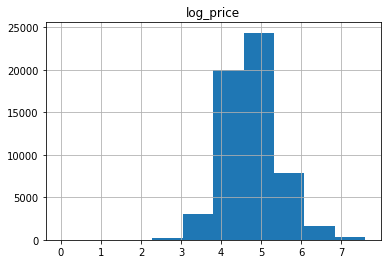

In [15]:
df_imputed.hist(column='log_price')

As pictured above, the log price has a much more normal distribution. Another attribute we created is the host_since_days, a calculation of how many days a host has been active, defined as the days they became a host subtracted from the current date.

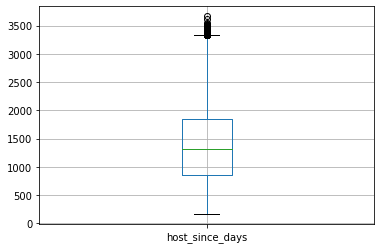

In [16]:
df_imputed.boxplot(column='host_since_days')

This appears to be right-skewed, with a number of outliers. Some of the hosts look to have been active for a very long time. Another "time-based" variable we created is the length_amenities variable. Some listings have new amenities added, and we created length amenities to create a metric similar to host_since_days.

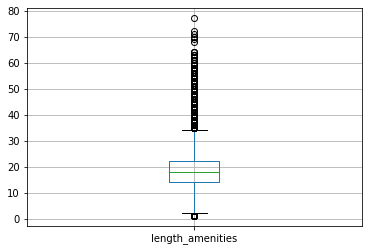

In [17]:
df_imputed.boxplot(column='length_amenities')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027955D5EB08>]],
      dtype=object)

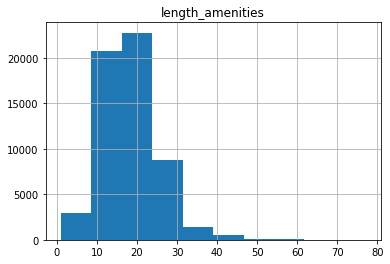

In [18]:
df_imputed.hist(column='length_amenities')

Very heavy right skew. There are a number of amenities that are very new, which pushes the distribution low, but the large concentration of smaller values pushes the handful of older amenities into outlier territory.

# Modeling and Evaluation 1

<i><b>10 pts.</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</i>

In [ ]:
#focus on precision with f measure

# Modeling and Evaluation 2

<i><b>10 pts.</b> Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</i>

In [ ]:
#cross validation w test holdout

# Modeling and Evaluation 3

<i><b>20 pts.</b> Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</i>

In [ ]:
#RF, KNN regression, logistic regression

# Logistic Regression

In [19]:
#logistic regression prep
df_logistic = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'description',
                      'latitude', 'longitude', 'name', 'neighbourhood', 'review_scores_rating',
                      'thumbnail_url', 'zipcode'], axis=1)
categorical_vars = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
df_logistic[categorical_vars].apply(lambda x: len(x.value_counts()), axis=0)

property_type          32
room_type               3
bed_type                5
cancellation_policy     5
city                    6
dtype: int64

In [20]:
df.property_type.value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Lighthouse                1
Island                    1
Parking Space             1
Casa particular           1
Name: property_type,

In [22]:
#delete property type because too many values 
df_logistic.drop(['property_type'], axis=1, inplace=True)
df_logistic.info()

KeyError: "['property_type'] not found in axis"

In [23]:
df_logistic.dropna(inplace=True)

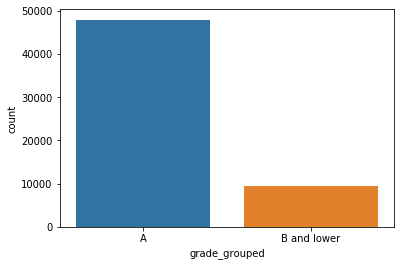

In [24]:
sns.countplot(data=df_logistic, x='grade_grouped')

In [26]:
#stacked bar chart of percentages
(ggplot(df_logistic, aes('city', fill='grade_grouped'))
 + geom_bar( position='fill')
)


NameError: name 'ggplot' is not defined

In [ ]:
(ggplot(df_logistic, aes('parking', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('pool', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('kitchen', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('air_conditioning', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('TV', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('internet', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('instant_bookable', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('room_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)


In [ ]:
(ggplot(df_logistic, aes('bed_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('cleaning_fee', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('host_has_profile_pic', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('host_identity_verified', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('cancellation_policy', fill='grade_grouped'))
 + geom_bar( position='fill')
)


In [27]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57388 entries, 0 to 57388
Data columns (total 31 columns):
room_type                 57388 non-null category
accommodates              57388 non-null int64
bathrooms                 57388 non-null float64
bed_type                  57388 non-null category
cancellation_policy       57388 non-null category
cleaning_fee              57388 non-null bool
city                      57388 non-null category
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57388 non-null bool
host_identity_verified    57388 non-null bool
host_response_rate        57388 non-null float64
host_since                57388 non-null datetime64[ns]
instant_bookable          57388 non-null bool
last_review               57388 non-null datetime64[ns]
number_of_reviews         57388 non-null int64
bedrooms                  57388 non-null int64
beds                      57388 non-null int64
price                     57388 non-null float64
grad

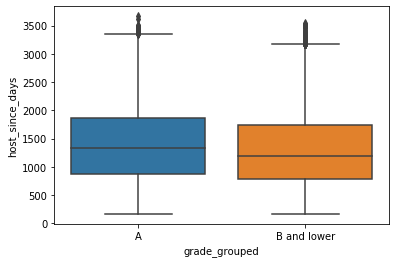

In [28]:
sns.boxplot(x='grade_grouped', y='host_since_days', data=df_logistic)

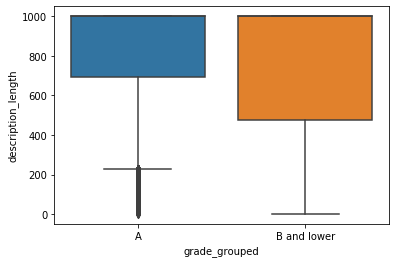

In [29]:
sns.boxplot(x='grade_grouped', y='description_length', data=df_logistic)

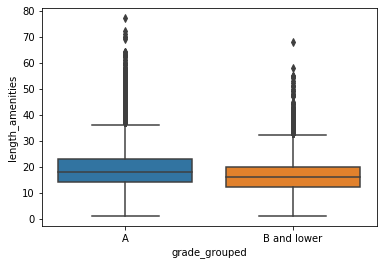

In [30]:
sns.boxplot(x='grade_grouped', y='length_amenities', data=df_logistic)

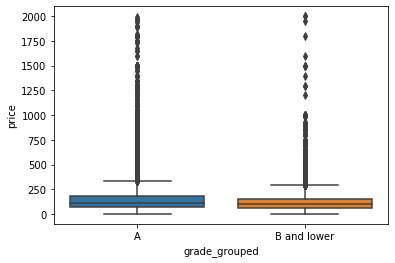

In [31]:
sns.boxplot(x='grade_grouped', y='price', data=df_logistic)

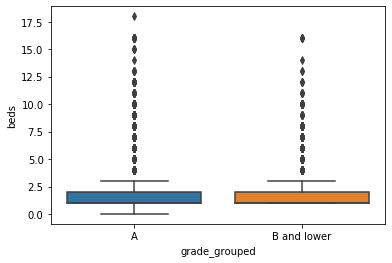

In [32]:
sns.boxplot(x='grade_grouped', y='beds', data=df_logistic)

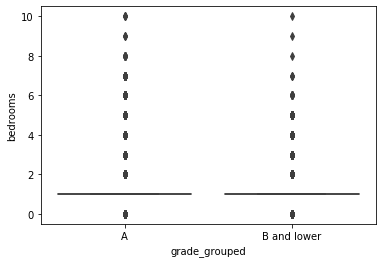

In [33]:
sns.boxplot(x='grade_grouped', y='bedrooms', data=df_logistic)

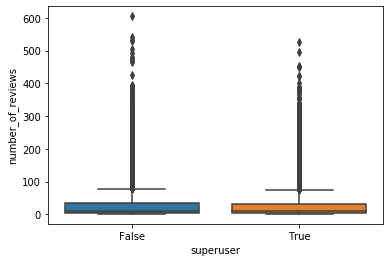

In [34]:
sns.boxplot(x='superuser', y='number_of_reviews', data=df_logistic)

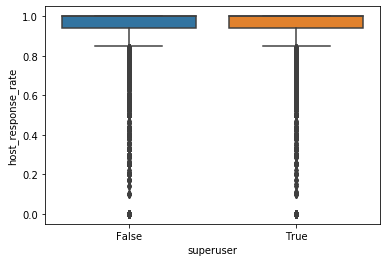

In [35]:
sns.boxplot(x='superuser', y='host_response_rate', data=df_logistic)

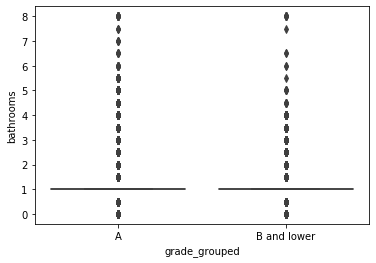

In [36]:
sns.boxplot(x='grade_grouped', y='bathrooms', data=df_logistic)

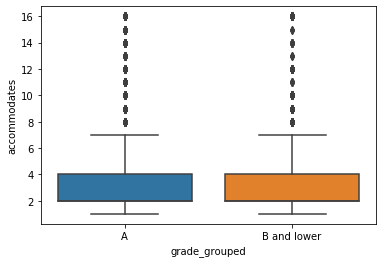

In [37]:
sns.boxplot(x='grade_grouped', y='accommodates', data=df_logistic)

# Logistic Regression without Scaling

In [38]:
# Create dummy variables
categorical_vars = ['parking', 'pool', 'kitchen', 'air_conditioning', 'TV', 'internet', 'instant_bookable',
                   'host_identity_verified', 'host_has_profile_pic', 'city', 'cleaning_fee', 'cancellation_policy',
                   'bed_type', 'room_type']

dummy_df = pd.get_dummies(df_logistic[categorical_vars], drop_first=True)

df_logistic_dummy = pd.concat([df_logistic, dummy_df], axis=1)

df_logistic_dummy.head()

,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,number_of_reviews,bedrooms,beds,price,grade,amenities_new,length_amenities,internet,TV,air_conditioning,kitchen,pool,parking,description_length,superuser,host_since_days,grade_grouped,parking,pool,kitchen,air_conditioning,TV,internet,instant_bookable,host_identity_verified,host_has_profile_pic,cleaning_fee,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
0,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,2016-06-18,True,True,0.924026,2012-03-26,False,2016-07-18,2,1,1,150.0,A,"[wireless internet, air conditioning, kitchen,...",9,True,False,True,True,False,False,211,True,2179,A,False,False,True,True,False,True,False,True,True,True,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,2017-08-05,True,False,1.000000,2017-06-19,True,2017-09-23,6,3,3,169.0,A,"[wireless internet, air conditioning, kitchen,...",15,True,False,True,True,False,False,1000,False,268,A,False,False,True,True,False,True,True,False,True,True,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,2017-04-30,True,True,1.000000,2016-10-25,True,2017-09-14,10,1,3,145.0,A,"[tv, cable tv, wireless internet, air conditio...",19,True,True,True,True,False,False,1000,False,505,A,False,False,True,True,True,True,True,True,True,True,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,2015-05-12,True,True,1.000000,2015-03-01,True,2017-01-22,4,0,1,115.0,F,"[tv, internet, wireless internet, air conditio...",12,True,True,True,True,False,False,699,False,1109,B and lower,False,False,True,True,True,True,True,True,True,True,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,Private room,2,1.0,Real Bed,strict,True,SF,2017-08-27,True,True,1.000000,2017-06-07,True,2017-09-05,3,1,1,85.0,A,"[tv, wireless internet, heating, smoke detecto...",10,True,True,False,False,False,False,1000,False,280,A,False,False,False,False,True,True,True,True,True,True,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [39]:
#delete categorical variables
for x in categorical_vars:
    if x in df_logistic_dummy:
        del df_logistic_dummy[x]

df_logistic_dummy.head()

,accommodates,bathrooms,first_review,host_response_rate,host_since,last_review,number_of_reviews,bedrooms,beds,price,grade,amenities_new,length_amenities,description_length,superuser,host_since_days,grade_grouped,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
0,3,1.0,2016-06-18,0.924026,2012-03-26,2016-07-18,2,1,1,150.0,A,"[wireless internet, air conditioning, kitchen,...",9,211,True,2179,A,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,7,1.0,2017-08-05,1.000000,2017-06-19,2017-09-23,6,3,3,169.0,A,"[wireless internet, air conditioning, kitchen,...",15,1000,False,268,A,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,5,1.0,2017-04-30,1.000000,2016-10-25,2017-09-14,10,1,3,145.0,A,"[tv, cable tv, wireless internet, air conditio...",19,1000,False,505,A,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,2,1.0,2015-05-12,1.000000,2015-03-01,2017-01-22,4,0,1,115.0,F,"[tv, internet, wireless internet, air conditio...",12,699,False,1109,B and lower,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,2,1.0,2017-08-27,1.000000,2017-06-07,2017-09-05,3,1,1,85.0,A,"[tv, wireless internet, heating, smoke detecto...",10,1000,False,280,A,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [40]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57388 entries, 0 to 57388
Data columns (total 31 columns):
room_type                 57388 non-null category
accommodates              57388 non-null int64
bathrooms                 57388 non-null float64
bed_type                  57388 non-null category
cancellation_policy       57388 non-null category
cleaning_fee              57388 non-null bool
city                      57388 non-null category
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57388 non-null bool
host_identity_verified    57388 non-null bool
host_response_rate        57388 non-null float64
host_since                57388 non-null datetime64[ns]
instant_bookable          57388 non-null bool
last_review               57388 non-null datetime64[ns]
number_of_reviews         57388 non-null int64
bedrooms                  57388 non-null int64
beds                      57388 non-null int64
price                     57388 non-null float64
grad

In [41]:
#delete amenities_new because used to create other variables
del df_logistic_dummy['amenities_new']

#delete host_since because used to create host_since_days
del df_logistic_dummy['host_since']

#delete grade and superuser because redundant with grouped_grade
del df_logistic_dummy['grade']
del df_logistic_dummy['superuser']

In [42]:
#remove timestamps
del df_logistic_dummy['first_review']
del df_logistic_dummy['last_review']

df_logistic_dummy.head()

,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,description_length,host_since_days,grade_grouped,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
0,3,1.0,0.924026,2,1,1,150.0,9,211,2179,A,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,7,1.0,1.000000,6,3,3,169.0,15,1000,268,A,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,5,1.0,1.000000,10,1,3,145.0,19,1000,505,A,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,2,1.0,1.000000,4,0,1,115.0,12,699,1109,B and lower,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,2,1.0,1.000000,3,1,1,85.0,10,1000,280,A,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [43]:
#Creating training and testing data
from sklearn.model_selection import ShuffleSplit
X = df_logistic_dummy.drop(['grade_grouped'], axis=1).values
X

array([[3.        , 1.        , 0.92402581, ..., 1.        , 0.        ,
        0.        ],
       [7.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [5.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [4.        , 2.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [5.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [4.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [44]:
y = df_logistic_dummy['grade_grouped'].values
y

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

In [45]:
#create cross validation object for 80/20 split
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
cv_object

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
#create logistic regression object
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
accuracies

array([0.83176512, 0.83464018, 0.82915142])

# Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
cv_strat_obj = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, train_size=0.8, random_state=0)
X_rf = df_imputed.drop(['grade_grouped'], axis=1).values
y_rf = df_imputed['grade_grouped'].values
cv_strat_obj.split(X_rf, y_rf)
cv_strat_obj

StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=0.8)

# Modeling and Evaluation 4

<i><b>10 pts.</b> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</i>

In [ ]:
#Conf matrix, ROC curve, plotting feature importance/accuracy, MSE? Scree plot for K neighbors

# Modeling and Evaluation 5

<i><b>10 pts.</b> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.</i>

In [ ]:
#focus on precision with f measure, p test, check 7.17 module

# Modeling and Evaluation 6

<i><b>10 pts.</b> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</i>

In [ ]:
#feature importance from RF, iterate/optimize K neighbors, f test on regression

# Deployment

<i><b>5 pts.</b> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</i>

In [ ]:
#clarify in class, explaining profit to shareholders (superhosts provide more to Airbnb than regular hosts, we can identify users that meet those requirements and can actively recruit for the program)

# Exceptional Work

<i><b>10 pts.</b> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</i>

In [ ]:
#smoat, lasso/ridge